In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Once the repo is cloned then:
#best practice remove and reeinstal fspec


# instal using the setup.py inside the sam2 repo
#pip install e .
#pip install -e ".[demo]"


#install also to vizualize figures
# !sudo apt-get update
# !sudo apt-get install -y libgl1-mesa-glx
# !sudo apt-get install -y libglib2.0-0

# #Necessary dependencies
# !rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
# !pip install fsspec==2024.6.1 --force-reinstall --no-deps
# !pip install shapely
# !pip install s3fs
# !pip install rasterio

## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Geting the image from Solafune competition uploaded to my s3 bucket

# Finetuning by retraining the model with solafune's data

In [4]:
import numpy as np
import rasterio
from shapely.geometry import Polygon
from shapely.ops import transform
import cv2
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
# Load Json
import s3fs
import json
import torch.optim as optim
from torch.cuda.amp import GradScaler
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator



In [5]:

train_annotation_s3_uri = 's3://solafune/train_annotation.json'


def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return torch.tensor(np.array(mask), dtype=torch.float32)

def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized

def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None
    
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data


# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'



In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

def read_batch(image_filenames, annotations, image_s3_prefix):
    # Select a random image
    image_filename = random.choice(image_filenames)
    image_s3_uri = os.path.join(image_s3_prefix, image_filename)
    
    # Load image using the existing function
    image = load_image(image_s3_uri)
    
    # Load annotations
    annotation = load_annotations(annotations, image_filename)
    
    height, width = image.shape[:2]
    masks = []
    points = []
    
    for ann in annotation:
        mask = polygon_to_mask(ann['segmentation'], width, height).numpy()
        masks.append(mask)

        # Choose a random point from the mask
        coords = np.argwhere(mask > 0)
        if len(coords) == 0:
            continue  # skip empty masks
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([yx[1], yx[0]])  # Store as (x, y) coordinates
    
    return image, np.array(masks), np.array(points)


In [7]:

# Load the model
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_l.yaml" #"sam2_hiera_l.yaml" for large
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# # Load the saved model state
# saved_state = torch.load("model.torch")
# predictor.model.load_state_dict(saved_state)

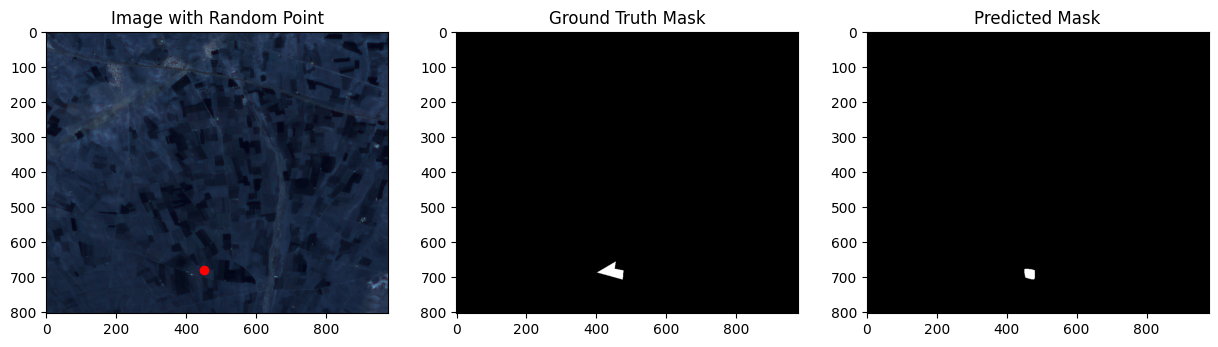

[[451 680]]


In [8]:


# Function to visualize the image, GT mask, and predicted mask
def visualize_image_and_masks(image, gt_mask, prd_mask, point):
    plt.figure(figsize=(15, 5))

    # Plot image with random point
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.scatter(point[0], point[1], color='red')
    plt.title("Image with Random Point")

    # Plot GT mask
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(prd_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Test the read_batch function and visualize the result
image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Set image in the predictor
predictor.set_image(image)

# Use the first point in the batch
input_point = points[0].reshape(1, 2)  # Correct shape for the point
input_label = np.array([1])  # Assuming binary classification for points

# Generate prompt and mask predictions using the predict method
masks_pred, scores, logits = predictor.predict(
    point_coords=input_point,  # Point coordinates
    point_labels=input_label,  # Labels for the point (foreground/background)
    multimask_output=False  # Single mask output
)

prd_mask = masks_pred[0]  # Get the predicted mask

# Visualize
visualize_image_and_masks(image, masks[0], prd_mask, points[0])
print(input_point)


In [9]:
import torch
import torch.optim as optim
import numpy as np

# Convert model to use float16
predictor.model.half()

# Optimizer
optimizer = optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision

# Training loop
for itr in range(1000):
    with torch.cuda.amp.autocast():
        # Read a batch of data
        image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)
        
        # Set image in the predictor
        predictor.set_image(image)
        
        # Convert ground truth masks to a tensor
        gt_masks_tensor = torch.tensor(masks, dtype=torch.float16).unsqueeze(0).cuda()

        # Use the first point in the batch
        input_point = points[0].reshape(1, 2)
        input_label = np.array([1])  # Assuming binary classification for points

        # Generate prompt and mask predictions using the predict method
        masks_pred, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
            normalize_coords=False
        )

        # Ensure the predicted mask is part of the computational graph
        prd_mask = torch.tensor(masks_pred[0], dtype=torch.float32, requires_grad=True).unsqueeze(0).cuda()

        # Segmentation loss calculation (cross-entropy loss)
        seg_loss = (-gt_masks_tensor * torch.log(prd_mask + 1e-5) - 
                    (1 - gt_masks_tensor) * torch.log(1 - prd_mask + 1e-5)).mean()

        # IOU Score loss calculation
        inter = (gt_masks_tensor * (prd_mask > 0.5)).sum((1, 2))
        union = (gt_masks_tensor.sum((1, 2)) + (prd_mask > 0.5).sum((1, 2)) - inter)
        iou = inter / (union + 1e-5)
        score_loss = torch.abs(scores[0] - iou.mean()).mean()

        # Total loss
        loss = seg_loss + score_loss * 0.05

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # Check if the scaler has recorded any inf/nan values
        found_inf_per_device = scaler._found_inf_per_device(optimizer)
        optimizer.step()  # Standard optimizer step
        if any(found_inf_per_device.values()):
            scaler.update()  # Only update scaler if inf/nan values were recorded

        # Clear memory
        del gt_masks_tensor, prd_mask, masks_pred, scores, logits
        torch.cuda.empty_cache()

        if itr % 10 == 0:
            torch.save(predictor.model.state_dict(), "model_large.torch")
            print(f"Model saved at iteration {itr}")

        # Display results (optional)
        if itr % 1 == 0:
            print(f"Iteration {itr}, Loss: {loss.item():.4f}, IOU: {iou.mean().item():.4f}")


Model saved at iteration 0
Iteration 0, Loss: 2.0790, IOU: 0.0008
Iteration 1, Loss: 0.0511, IOU: 0.0008
Iteration 2, Loss: 0.1454, IOU: 0.0001
Iteration 3, Loss: 0.2520, IOU: 0.0000


/tmp/ipykernel_17589/2021245419.py:18: RuntimeWarning: invalid value encountered in cast
  image_normalized = image_normalized.astype(np.uint8)


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.20 GiB. GPU 0 has a total capacity of 21.96 GiB of which 4.99 GiB is free. Process 20446 has 16.96 GiB memory in use. Of the allocated memory 16.44 GiB is allocated by PyTorch, and 292.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Test the results

In [ ]:
import matplotlib.pyplot as plt
import torch

# Function to visualize the image, GT mask, and predicted masks from different models
def visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, point):
    plt.figure(figsize=(20, 4))

    # Plot image with random point
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.scatter(point[0], point[1], color='red')
    plt.title("Image with Random Point")

    # Plot GT mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask (Current saved state)
    plt.subplot(1, 4, 3)
    plt.imshow(prd_mask_saved, cmap='gray')
    plt.title("Current Saved State")

    # Plot Predicted mask (SAM2 checkpoint)
    plt.subplot(1, 4, 4)
    plt.imshow(prd_mask_checkpoint, cmap='gray')
    plt.title("SAM2 Checkpoint")

    plt.show()

# Test the read_batch function and visualize the result
image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Use the first point in the batch
input_point = points[0].reshape(1, 2)  # Correct shape for the point
input_label = np.array([1])  # Assuming binary classification for points


# 1. Load the saved model state and predict
saved_state = torch.load("model.torch")
predictor.model.load_state_dict(saved_state)
predictor.set_image(image)
masks_pred_saved, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)
prd_mask_saved = masks_pred_saved[0]

# 2. Load the SAM2 checkpoint and predict
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_small.pt"  # Adjust to large if needed
model_cfg = "sam2_hiera_s.yaml"  # Adjust to large if needed
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor_checkpoint = SAM2ImagePredictor(sam2_model)
predictor_checkpoint.set_image(image)
masks_pred_checkpoint, _, _ = predictor_checkpoint.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)
prd_mask_checkpoint = masks_pred_checkpoint[0]

# Visualize all the results
visualize_image_and_masks(image, masks[0], prd_mask_saved, prd_mask_checkpoint, points[0])

